In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/esol-preprocessed/GNN.ipynb
/kaggle/input/esol-preprocessed/dataset/ESOL/description.md
/kaggle/input/esol-preprocessed/dataset/ESOL/delaney-processed.csv
/kaggle/input/esol-preprocessed/paper/2010.05234v3.pdf


### Common libraries 

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Uploaded and loaded the dataset

In [3]:
data = pd.read_csv('/kaggle/input/esol-preprocessed/dataset/ESOL/delaney-processed.csv')
data.head()
print(data.columns)
print(data.describe())
data.head()


Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')
       ESOL predicted log solubility in mols per litre  Minimum Degree  \
count                                      1128.000000     1128.000000   
mean                                         -2.988192        1.058511   
std                                           1.683220        0.238560   
min                                          -9.702000        0.000000   
25%                                          -3.948250        1.000000   
50%                                          -2.870000        1.000000   
75%                                          -1.843750        1.000000   
max                                           1.091000        2.000000   

       Molecular Weight  N

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


### EDA

#### Step 1: Drop Unnecessary Columns

Remove the following columns from the dataset:

- **Compound ID**: This is a non-numeric identifier and not useful for modeling.
- **ESOL predicted log solubility**: This is a prediction from a baseline model and should not be used in training or evaluation.


In [4]:
data = data.drop(columns=[
    'Compound ID',
    'ESOL predicted log solubility in mols per litre'
])

#### Step 2: Handle missing values (if any)

In [5]:
data = data.dropna()

#### Step 3: Separate features and target

In [6]:
X = data.drop(columns=['measured log solubility in mols per litre', 'smiles'])
y = data['measured log solubility in mols per litre']

#### Custom SMILES → Graph conversion (using RDKit)
To use **Graph Neural Networks (GNNs)** for molecular property prediction (e.g., solubility), molecules must be represented as graphs. This involves converting **SMILES** strings into graph objects, where:

- **Nodes** = atoms (with features)
- **Edges** = bonds (with optional features)

In [7]:
!pip install rdkit
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [8]:
from rdkit import Chem
import torch
from torch_geometric.data import Data

def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid SMILES

    # Extract atom features (simple example: atomic number)
    node_feats = []
    for atom in mol.GetAtoms():
        node_feats.append([atom.GetAtomicNum()])

    # Extract edge indices (bidirectional)
    edges = []
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        edges.append((start, end))
        edges.append((end, start))  # undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_feats, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y)


#### Step 4: Apply conversion in dataset

In [9]:
graphs = []

for _, row in data.iterrows():
    graph = smiles_to_graph(row['smiles'], row['measured log solubility in mols per litre'])
    if graph is not None:
        graphs.append(graph)

#### Step 5: Split into Train/Test Sets (using random split)

In [10]:
from sklearn.model_selection import train_test_split
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)


In [11]:
print(f"Total graphs: {len(graphs)}")
print(f"Training graphs: {len(train_graphs)}")
print(f"Testing graphs: {len(test_graphs)}")

Total graphs: 1128
Training graphs: 902
Testing graphs: 226


### For the fun part (ML stuffs)

#### Create DataLoaders for GNN Training

In [12]:
from torch_geometric.loader import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Check batch structure
for batch in train_loader:
    print(batch)
    break


DataBatch(x=[486, 1], edge_index=[2, 1030], y=[32], batch=[486], ptr=[33])


#### What it means: 
**Batched Graph Representation**

This is a single batch of **32 graphs**, now represented as **one combined batched graph**. Here's what each component means:

| Attribute             | Shape           | Meaning                                                                 |
|----------------------|-----------------|-------------------------------------------------------------------------|
| `x = [453, 1]`        | 453 total atoms (nodes), each with 1 feature (atomic number)             |
| `edge_index = [2, 940]` | 940 total edges (directed, so bonds × 2), across all 32 graphs         |
| `y = [32]`            | One scalar label per graph (solubility); 32 graphs in this batch         |
| `batch = [453]`       | Tensor that maps each of the 453 atoms to one of the 32 graphs           |
| `ptr = [33]`          | Internal indexing (used in `Batch` object); marks the graph boundaries   |


#### Full tranining script

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=1, out_channels=64)
        self.conv2 = GCNConv(in_channels=64, out_channels=64)
        self.lin = nn.Linear(64, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Training and evaluation functions
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)

    for batch in loop:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out.squeeze(), batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=False)
        for batch in loop:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds.extend(out.squeeze().cpu().numpy())
            targets.extend(batch.y.cpu().numpy())

    rmse = mean_squared_error(targets, preds, squared=False)
    return rmse

#### Main Training Loop (with Checkpointing)

In [14]:
# Set device and init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Save best model
best_val_rmse = float('inf')
checkpoint_path = "best_model.pt"

# For plotting
train_losses = []
val_rmses = []

# Training loop
epochs = 50
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    val_rmse = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    print(f"Train Loss: {train_loss:.4f} | Val RMSE: {val_rmse:.4f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), checkpoint_path)
        print("-----------------> Saved best model.")

# Final evaluation
print("\n Training complete.")
print(f"Best Validation RMSE: {best_val_rmse:.4f}")



Epoch 1/50


Train Loss: 7.9958 | Val RMSE: 2.3324
-----------------> Saved best model.

Epoch 2/50


Train Loss: 5.0370 | Val RMSE: 2.3123
-----------------> Saved best model.

Epoch 3/50


Train Loss: 5.0040 | Val RMSE: 2.3129

Epoch 4/50


Train Loss: 4.9966 | Val RMSE: 2.3048
-----------------> Saved best model.

Epoch 5/50


Train Loss: 4.9579 | Val RMSE: 2.3034
-----------------> Saved best model.

Epoch 6/50


Train Loss: 4.9224 | Val RMSE: 2.2991
-----------------> Saved best model.

Epoch 7/50


Train Loss: 4.9211 | Val RMSE: 2.2952
-----------------> Saved best model.

Epoch 8/50


Train Loss: 4.8966 | Val RMSE: 2.2884
-----------------> Saved best model.

Epoch 9/50


Train Loss: 4.8814 | Val RMSE: 2.2849
-----------------> Saved best model.

Epoch 10/50


Train Loss: 4.8495 | Val RMSE: 2.2800
-----------------> Saved best model.

Epoch 11/50


Train Loss: 4.8464 | Val RMSE: 2.2756
-----------------> Saved best model.

Epoch 12/50


Train Loss: 4.8111 | Val RMSE: 2.2751
-----------------> Saved best model.

Epoch 13/50


Train Loss: 4.7640 | Val RMSE: 2.2683
-----------------> Saved best model.

Epoch 14/50


Train Loss: 4.7421 | Val RMSE: 2.2640
-----------------> Saved best model.

Epoch 15/50


Train Loss: 4.7201 | Val RMSE: 2.2590
-----------------> Saved best model.

Epoch 16/50


Train Loss: 4.7176 | Val RMSE: 2.2603

Epoch 17/50


Train Loss: 4.6823 | Val RMSE: 2.2508
-----------------> Saved best model.

Epoch 18/50


Train Loss: 4.6538 | Val RMSE: 2.2465
-----------------> Saved best model.

Epoch 19/50


Train Loss: 4.6288 | Val RMSE: 2.2412
-----------------> Saved best model.

Epoch 20/50


Train Loss: 4.6042 | Val RMSE: 2.2398
-----------------> Saved best model.

Epoch 21/50


Train Loss: 4.5931 | Val RMSE: 2.2307
-----------------> Saved best model.

Epoch 22/50


Train Loss: 4.5717 | Val RMSE: 2.2282
-----------------> Saved best model.

Epoch 23/50


Train Loss: 4.5715 | Val RMSE: 2.2309

Epoch 24/50


Train Loss: 4.5075 | Val RMSE: 2.2161
-----------------> Saved best model.

Epoch 25/50


Train Loss: 4.4786 | Val RMSE: 2.2120
-----------------> Saved best model.

Epoch 26/50


Train Loss: 4.4604 | Val RMSE: 2.2049
-----------------> Saved best model.

Epoch 27/50


Train Loss: 4.4381 | Val RMSE: 2.2031
-----------------> Saved best model.

Epoch 28/50


Train Loss: 4.4320 | Val RMSE: 2.2016
-----------------> Saved best model.

Epoch 29/50


Train Loss: 4.4049 | Val RMSE: 2.1972
-----------------> Saved best model.

Epoch 30/50


Train Loss: 4.3979 | Val RMSE: 2.1955
-----------------> Saved best model.

Epoch 31/50


Train Loss: 4.3973 | Val RMSE: 2.1892
-----------------> Saved best model.

Epoch 32/50


Train Loss: 4.3739 | Val RMSE: 2.1981

Epoch 33/50


Train Loss: 4.4511 | Val RMSE: 2.1846
-----------------> Saved best model.

Epoch 34/50


Train Loss: 4.3405 | Val RMSE: 2.1808
-----------------> Saved best model.

Epoch 35/50


Train Loss: 4.3300 | Val RMSE: 2.2276

Epoch 36/50


Train Loss: 4.3621 | Val RMSE: 2.1771
-----------------> Saved best model.

Epoch 37/50


Train Loss: 4.3215 | Val RMSE: 2.1808

Epoch 38/50


Train Loss: 4.3210 | Val RMSE: 2.1764
-----------------> Saved best model.

Epoch 39/50


Train Loss: 4.3351 | Val RMSE: 2.1760
-----------------> Saved best model.

Epoch 40/50


Train Loss: 4.3398 | Val RMSE: 2.1739
-----------------> Saved best model.

Epoch 41/50


Train Loss: 4.3262 | Val RMSE: 2.1804

Epoch 42/50


Train Loss: 4.3102 | Val RMSE: 2.1731
-----------------> Saved best model.

Epoch 43/50


Train Loss: 4.2988 | Val RMSE: 2.1817

Epoch 44/50


Train Loss: 4.3391 | Val RMSE: 2.1785

Epoch 45/50


Train Loss: 4.3317 | Val RMSE: 2.1828

Epoch 46/50


Train Loss: 4.3801 | Val RMSE: 2.1719
-----------------> Saved best model.

Epoch 47/50


Train Loss: 4.3046 | Val RMSE: 2.1748

Epoch 48/50


Train Loss: 4.3184 | Val RMSE: 2.1722

Epoch 49/50


Train Loss: 4.2922 | Val RMSE: 2.1723

Epoch 50/50


Train Loss: 4.2943 | Val RMSE: 2.1718
-----------------> Saved best model.

 Training complete.
Best Validation RMSE: 2.1718


#### Load and use the best model

In [15]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)

# Evaluate on test set again
test_rmse = evaluate(model, test_loader, device)
print(f"Test RMSE (best model): {test_rmse:.4f}")


Test RMSE (best model): 2.1718


#### Plot Loss & RMSE

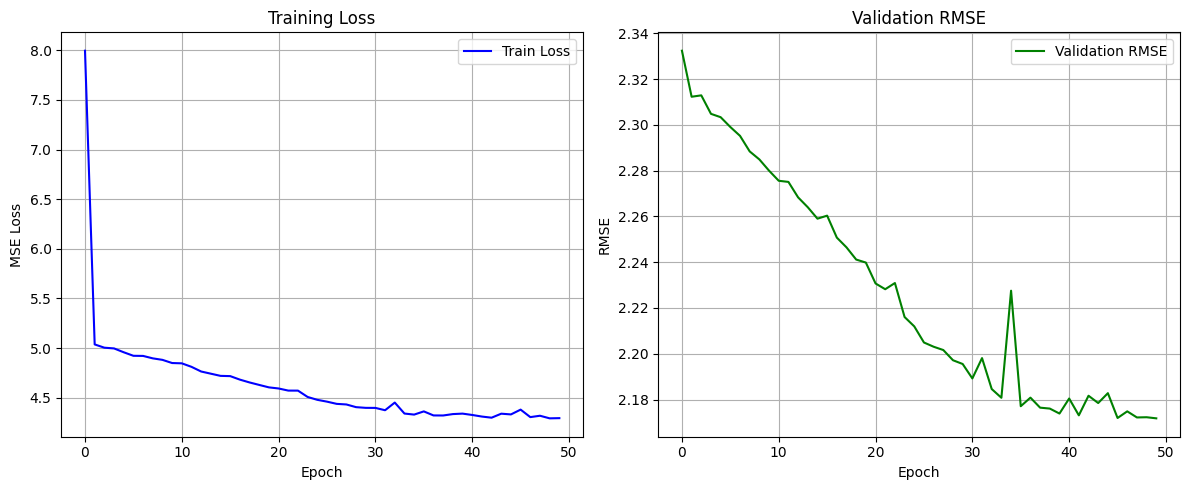

In [16]:
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(val_rmses, label="Validation RMSE", color='green')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
